In [3]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [4]:
# 원유 데이터 불러오기
_VIX = pd.read_csv('./csv/_VIX.csv')
_KOSPI = pd.read_csv('./csv/_KOSPI.csv')

In [5]:
_KOSPI.info()

drop_columns = ['Unnamed: 0']
_KOSPI.drop(drop_columns, axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  247 non-null    int64 
 1   date        247 non-null    object
 2   Close       247 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.9+ KB


In [6]:
# 데이터 타입 변환
_KOSPI["KOSPI"] = pd.to_numeric(_KOSPI["Close"].str.replace(',', ''))
_KOSPI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    247 non-null    object 
 1   Close   247 non-null    object 
 2   KOSPI   247 non-null    float64
dtypes: float64(1), object(2)
memory usage: 5.9+ KB


In [7]:
_VIX.info()

drop_columns = ['Unnamed: 0']
_VIX.drop(drop_columns, axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  256 non-null    int64  
 1   date        256 non-null    object 
 2   Close       256 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.1+ KB


In [8]:
# 컬럼명 변경 및 삭제
_VIX = _VIX.rename(columns={'Close':'VIX'})

drop_columns = ['Close']
_KOSPI.drop(drop_columns, axis=1, inplace=True)

In [9]:
# 병합
vix_kospi = pd.merge(_VIX, _KOSPI, how='inner', on='date')
vix_kospi[['date', 'VIX', 'KOSPI']]

,date,VIX,KOSPI
0,21/04/01,17.33,3087.40
1,21/04/02,17.33,3112.80
2,21/04/05,17.91,3120.83
3,21/04/06,18.12,3127.08
4,21/04/07,17.16,3137.41
...,...,...,...
237,22/03/25,20.81,2729.98
238,22/03/28,19.63,2729.56
239,22/03/29,18.90,2741.07
240,22/03/30,19.33,2746.74


In [10]:
# 시각화
fig = px.line(vix_kospi, x='date', y=["VIX"])
fig = px.line(vix_kospi, x='date', y=["KOSPI"])
fig.show()

In [11]:
# 에러 함수들 정의 후 선형회귀 학습/예측
from sklearn.metrics import mean_absolute_error, mean_squared_error

# log 값 변환 시 NaN등의 이슈로 log()가 아닌 log1p()를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    sqaured_error = (log_y - log_pred) **2
    rmsle = np.sqrt(np.mean(sqaured_error))
    return rmsle

# 사이킷런의 mean_square_error()를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y,pred)
    # MAE는 scikit learn의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMLSE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

In [12]:
# 학습 데이터, 테스트 데이터 분리
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = vix_kospi['KOSPI']
X_features = vix_kospi.drop(['date', 'KOSPI'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=107)

# 선형회귀 적용 후 학습/예측/평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

print('Variance score:{0:.3f}'.format(r2_score(y_test, pred)))
print('절편 값 :',lr_reg.intercept_)
print('회귀 계수값 :', np.round(lr_reg.coef_))

RMLSE: 0.047, RMSE: 139.914, MAE: 119.282
Variance score:0.573
절편 값 : 3628.521500363449
회귀 계수값 : [-30.]


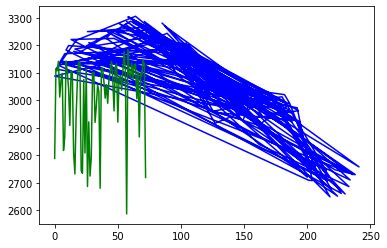

In [13]:
# plt.plot(X_train, color = 'k')
plt.plot(y_train, color = 'b')
plt.plot(pred, color = 'g')

In [14]:
# 예측값과 실제값 오차 확인
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측값을 서로 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값의 차이가 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

    real_count  predicted_count    diff
15     3161.66           2810.0  351.66
39     2741.07           3068.0  326.93
34     2746.74           3055.0  308.26
47     3244.04           2961.0  283.04
53     2768.85           3037.0  268.15


In [15]:
# 타겟값에 로그를 취해서 정규화

# 타겟 컬럼인 count를 log1p로 Log변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=107)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 exmp1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 테스트 데이터 셋의 Target값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

print('Variance score:{0:.3f}'.format(r2_score(y_test, pred)))
print('절편 값 :',lr_reg.intercept_)
print('회귀 계수값 :', lr_reg.coef_)

RMLSE: 0.047, RMSE: 140.067, MAE: 119.783
Variance score:0.584
절편 값 : 8.217367356838087
회귀 계수값 : [-0.01004002]


<AxesSubplot:>

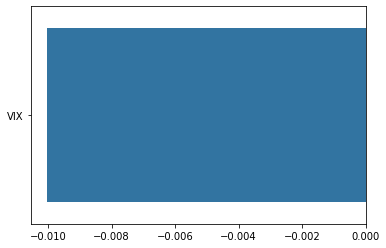

In [16]:
# 피처 별 회귀계수 확인

coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)